<a href="https://colab.research.google.com/github/apthagowda97/openvino_people_counter/blob/master/notebook/people_counter_faster_rcnn_colab/people_counter_faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
!pip install pycocotools
!git clone --depth 1 https://github.com/tensorflow/models
!curl -L "https://drive.google.com/u/0/uc?id=1OU10tV9iZg_Rw7RCDtC_tzloxtCxoYZN&export=download" --output input_video.mp4

Cloning into 'models'...
remote: Enumerating objects: 2662, done.
remote: Counting objects: 100% (2662/2662), done.
remote: Compressing objects: 100% (2328/2328), done.
remote: Total 2662 (delta 528), reused 1328 (delta 300), pack-reused 0
Receiving objects: 100% (2662/2662), 32.16 MiB | 24.86 MiB/s, done.
Resolving deltas: 100% (528/528), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    457      0 --:--:-- --:--:-- --:--:--   457
100 3214k    0 3214k    0     0  3047k      0 --:--:--  0:00:01 --:--:-- 3047k


In [3]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
pip install .
cd slim
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1113489 sha256=0269669e77c1cbcdc149dddeea5ca6b62a94248fc3c0f8bc9dbde27be8c2eb5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-wdovxtss/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
Processing /content/models/research/slim
  Created wheel for slim: filename=slim-0.1-cp36-none-any.whl size=231256 sha256=8a46179a4b58fb5eef9f8ca89f260038455c7bcc4f6f72944abfc3c702810376
  Stored in directory: /tmp/pip-ephem-wheel-cache-6dcbcocz/wheels/c0/cb/18/e76d02033e40846187fac06f0f855c6434d52aadf580451f20
Successfully built slim


object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [0]:
import numpy as np
import os
import pathlib
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import time
%matplotlib inline

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

utils_ops.tf = tf.compat.v1
tf.gfile = tf.io.gfile

In [0]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"
  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [6]:
model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
detection_model = load_model(model_name)

149127168/149119618 [==============================] - 1s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [7]:
detection_model.inputs

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]

In [8]:
detection_model.outputs

[<tf.Tensor 'detection_boxes:0' shape=(None, 100, 4) dtype=float32>,
 <tf.Tensor 'detection_classes:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'detection_scores:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'num_detections:0' shape=(None,) dtype=float32>]

In [0]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)


  return output_dict

In [0]:
def draw_boxes(frame, result,prob_threshold, width, height):
    new_conf = 0
    for i,conf in enumerate(result['detection_scores']):
        if conf >= prob_threshold:
            new_conf = conf
            box = result['detection_boxes'][i]
            xmin = int(box[1] * width)
            ymin = int(box[0] * height)
            xmax = int(box[3] * width)
            ymax = int(box[2] * height)
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    return frame,new_conf

start_time = 0
temp_flag = 0
count = 0
total = 0
duration = 0.0
duration_arr = []
count_arr = []

def postprocess(conf,frame_no,conf_arr,fps):
    global start_time,temp_flag,count,total,duration,duration_arr,count_arr
    if temp_flag == 0:
        if conf > 0:
            temp_flag = 1
            count = 1
            total = total + 1
            start_time = frame_no
    if temp_flag == 1:
        post_frames = conf_arr[-3:]
        if np.mean(post_frames) == 0:
            temp_flag = 0
            count = 0
            duration = ((frame_no)-start_time)/fps
            duration_arr.append(duration)
    count_arr.append(count)
    return

In [0]:
cap = cv2.VideoCapture('input_video.mp4')
cap.open('input_video.mp4') 
width = int(cap.get(3))
height = int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)
conf_arr = []
infr_arr = []
frame_no = 0
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("out.mp4", fourcc, 6, (width,height))

while cap.isOpened():
    ### TODO: Read from the video capture ###
    flag, frame = cap.read()
    frame_no = frame_no+1
    start_infr = time.time()
    if frame_no%5 == 0:
      if not flag:
          break
      ### TODO: Pre-process the image as needed ###
      key_pressed = cv2.waitKey(60)
      new_frame= np.copy(frame)
      output_dict = run_inference_for_single_image(detection_model, frame)
      out_frame,conf = draw_boxes(new_frame, output_dict,0.8, width, height)
      conf_arr.append(conf)
      postprocess(conf,frame_no,conf_arr,fps)
      infr_arr.append((time.time()-start_infr))
      out.write(out_frame)

out.release()
cap.release()
cv2.destroyAllWindows()

In [16]:
print(f'Total number of people counted: {total}')
print(f'Average duration: {np.mean(duration_arr):.2f} sec')
print(f'Average inferance time per frame: {np.mean(infr_arr):.2f} sec')
print(f'Total inferance time: {np.sum(infr_arr)/60:.2f} min for {len(infr_arr)} frames' )

Total number of people counted: 12
Average duration: 18.50 sec
Average inferance time per frame: 1.39 sec
Total inferance time: 6.45 min for 278 frames


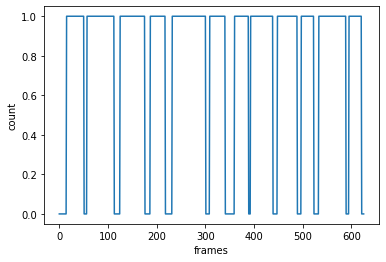

In [20]:
%matplotlib inline
plt.plot(count_arr)
plt.ylabel('count')
plt.xlabel('frames')
plt.show()

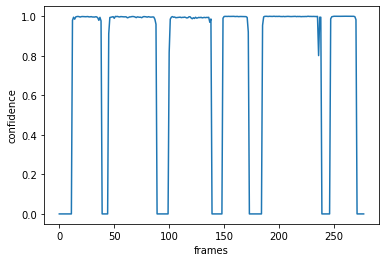

In [21]:
plt.plot(conf_arr)
plt.ylabel('confidence')
plt.xlabel('frames')
plt.show()

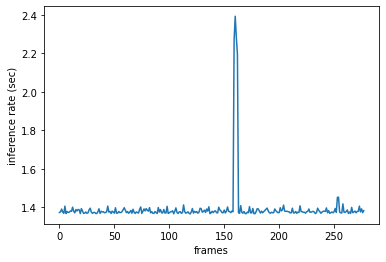

In [23]:
plt.plot(infr_arr)
plt.ylabel('inference rate (sec)')
plt.xlabel('frames')
plt.show()

In [0]:
from google.colab import files
files.download('out.mp4') 